# Library and Setup

In [258]:
import pandas as pd # Data management tools
import numpy as np # Mathematical operations
import psycopg2 # Access to SQL
import re # Regex and other lookup tools
import datetime

In [259]:
def fetch_table_to_df(conn, query):
    """"Extracts entire table(s) from an SQL database. 
    
    conn: Should be a connect function from psycopg2.
    query: Tables to be extracted from the database.

    """
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    column_names = [desc[0] for desc in cur.description]
    df = pd.DataFrame(rows, columns=column_names).replace({np.nan}, None)
    cur.close()
    return df

In [260]:
conn = psycopg2.connect(
    database="testing",
    user="postgres",
    password="forest25",
    host="localhost",
    port="5432"
)

In [261]:
tables = "tree_monitorings", "measurement_informations", "biomass_formulas", "tree_biomasses", 'taxonomies', 'tree_samplings', 'plot_informations', "site_informations"
for table in tables:
    table_name = f"{table}"
    globals()[table_name] = fetch_table_to_df(conn, f"SELECT * FROM {table}")

# Biomass Calculation

# Preparation

Python supports $pow()$, only need to remove $ sign from the equation

In [262]:
#replacements = {'pow' : '', ',' : '**'}
#biomass_formulas['formula_python'] = biomass_formulas['formula'].replace(replacements, regex = True).str.replace('$','')

biomass_formulas['formula_python'] = biomass_formulas['formula'].str.replace('$','') #Simpler, pow() exists in python as well

Changing data types for smooth operations

In [263]:
tree_monitorings[['tree_height', 'tree_dbh']] = tree_monitorings[['tree_height', 'tree_dbh']].astype('float')
taxonomies['id'] = taxonomies['id'].astype('int')
taxonomies['wood_density'] = taxonomies['wood_density'].astype('float')
tree_monitorings['taxonomy_id'] = tree_monitorings['taxonomy_id'].astype('int')

Current data shows combination of hasHeight+noDBH, noHeight+noDBH, hasHeight+hasDBH but no noHeight+hasDBH

In [264]:
tree_monitorings[['tree_height','tree_dbh']].notna().value_counts()

tree_height  tree_dbh
True         False       6301
False        False       4193
True         True        3234
Name: count, dtype: int64

Standardizing tree_species names (unfinished, need to deal with NAs)

In [265]:
tree_species = ['Suren', 'Kopi Liberika', 'Citrus', 'Casuarina','Other', 'Meranti','Soursop','Gaharu','Mango','Rosewood','Orange','Tengkurung','Durian','Cajuput','Jackfruit','Rambutan','Clove','Coffee', 'Lamtoro','Meranti Bakau', 'Meranti Bunga', 'Asam Gelugur','Avocado','Cempedak', 'Asam', 'Tampui', 'Sirsak', 'Kuras','Bitterbean','Mentangor']

In [266]:
#x = [next(iter(x), np.nan) 
#          for x in map(lambda x: difflib.get_close_matches(x, tree_species, cutoff = 0.7), tree_monitorings['tree_species']) if x]

## Full Census Biomass Calculation

Adding column of biomass_formula_id for simpler referencing in upcoming operations

In [267]:
dbh_exist = tree_monitorings['tree_dbh'].notna() # check which is not NA
height_exist = tree_monitorings['tree_height'].notna() # check which is not NA

trees_wood_density = [taxonomies.loc[taxonomies['id'] == tax_id, 'wood_density'].values[0] 
                if tax_id in taxonomies['id'].values else None
                for tax_id in tree_monitorings['taxonomy_id']]

In [268]:
for index, (dbh, height, wood) in enumerate(zip(dbh_exist, height_exist, trees_wood_density)):
    if dbh == 1 and height == 1:
        if (wood != wood or wood == None):
            tree_monitorings.loc[index, 'biomass_formulas_id'] = 7
        else:
            tree_monitorings.loc[index, 'biomass_formulas_id'] = 3
    elif (dbh == 1 and height == 0):
        tree_monitorings.loc[index, 'biomass_formulas_id'] = 5
    elif (dbh == 0 and height == 1):
        tree_monitorings.loc[index, 'biomass_formulas_id'] = 4
    else:
        tree_monitorings.loc[index, 'biomass_formulas_id'] = None

Filtering data from measurement_information which also exist in tree_monitorings

In [269]:
type1_measurement = measurement_informations[(measurement_informations['monitoring_id'].isin(tree_monitorings['id'])== True) & measurement_informations['monitoring_type'] == 1]

In [270]:
tree_monitorings['tree_cond'].value_counts(dropna = False)

tree_cond
0       8011
1       3084
None    2156
2        477
Name: count, dtype: int64

In [271]:
#measurement = measurement_informations[(measurement_informations['monitoring_id'].isin(tree_monitorings['id'])== True)]

In [272]:
taxonomy_dict = taxonomies.set_index('id')['wood_density'].to_dict() #Set wood identity for referral from taxonomy_id

biomass_index = [] #empty list for storing valid biomass ids
result = [] #empty list for storing results
for index_used in type1_measurement['monitoring_id']:
    tree_dbh     = tree_monitorings.loc[tree_monitorings['id'] == index_used,'tree_dbh'].values[0]
    tree_height  = tree_monitorings.loc[tree_monitorings['id'] == index_used,'tree_height'].values[0]
    biomass_id   = tree_monitorings.loc[tree_monitorings['id'] == index_used,'biomass_formulas_id'].values[0]
    tax_id       = tree_monitorings.loc[tree_monitorings['id'] == index_used,'taxonomy_id'].values[0]
    wood_density = taxonomy_dict.get(tax_id)
    if (biomass_id != biomass_id or biomass_id == None):
        continue
    else:
        biomass_form = biomass_formulas.loc[biomass_formulas['id'] == biomass_id, 'formula_python']
        for biomass in biomass_form:
            biomass_result = eval(biomass)
            result.append(biomass_result)
            biomass_index.append(index_used)
#            print("dbh:", tree_dbh,
#                  "height:", tree_height,
##                  "index:", index_used, 
 #                 "formula", biomass_form,
 #                 "result:", biomass_result)

### Creating Biomass Table/Dataframe

In [273]:
tree_biomasses_python = type1_measurement[type1_measurement['monitoring_id'].isin(biomass_index) == True]

In [274]:
tree_biomasses_python = tree_biomasses_python.drop(['id','timenow','start', 'end','username','notes','_xform_id','_xform_id_string','monitoring_order','month_monitoring','phase'], axis = 1)


In [275]:
tree_biomasses_python['result'] = result

In [276]:
tree_biomasses_python['taxonomy_id'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'taxonomy_id'].values[0] 
                if mon_id in tree_monitorings['id'].values else None
                for mon_id in tree_biomasses_python['monitoring_id']]

In [277]:
tree_biomasses_python['tree_species'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'tree_species'].values[0] 
                if mon_id in tree_monitorings['id'].values else None
                for mon_id in tree_biomasses_python['monitoring_id']]

In [278]:
tree_biomasses_python['tree_id'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'tree_id'].values[0] 
                if mon_id in tree_monitorings['id'].values else None
                for mon_id in tree_biomasses_python['monitoring_id']]

In [279]:
tree_biomasses_python['submission_time'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'submission_time'].values[0] 
                if mon_id in tree_monitorings['id'].values else None
                for mon_id in tree_biomasses_python['monitoring_id']]

In [280]:
tree_biomasses_python['updated_at'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


In [281]:
carbon = []
for res in result:
    if (res != res or res == None):
        continue
    else:
        carbon.append(res * 0.5 * 3.67) # biomass * 0.5 * 3.67
tree_biomasses_python['carbon'] = carbon

In [282]:
tree_biomasses_python['id'] = range(1,len(tree_biomasses_python)+1)

In [283]:
tree_biomasses_python = tree_biomasses_python[['id','monitoring_id','tree_id','tree_species','taxonomy_id','result','carbon','date_monitoring','submission_time','created_at','updated_at']]
tree_biomasses_python

,id,monitoring_id,tree_id,tree_species,taxonomy_id,result,carbon,date_monitoring,submission_time,created_at,updated_at
1653,1,62,AA01T0180,Meranti,5,0.000000,0.000000,2018-04-23,2019-03-29 14:36:00,2021-08-01 20:19:02,2024-12-04 14:02:59
1686,2,1,AA01T0001,Gaharu,4,0.030735,0.056398,2018-02-21,2019-03-29 14:02:38,2021-08-01 20:19:01,2024-12-04 14:02:59
1793,3,30838,BB-01-0-0024,Suren,64,0.295311,0.541896,2024-08-15,2024-09-11 00:00:00,2024-09-11 18:13:55,2024-12-04 14:02:59
1794,4,30839,BB-01-0-0026,Suren,64,0.144379,0.264936,2024-08-15,2024-09-11 00:00:00,2024-09-11 18:13:55,2024-12-04 14:02:59
1795,5,30840,BB-01-0-0027,Suren,64,0.329164,0.604016,2024-08-15,2024-09-11 00:00:00,2024-09-11 18:13:55,2024-12-04 14:02:59
...,...,...,...,...,...,...,...,...,...,...,...
18791,10581,36980,CL-10-0-1843,suren,64,0.473252,0.868417,2023-08-21,2024-09-11 00:00:00,2024-09-11 21:22:56,2024-12-04 14:02:59
18792,10582,36981,CL-10-0-1844,suren,64,0.577320,1.059382,2023-08-21,2024-09-11 00:00:00,2024-09-11 21:22:56,2024-12-04 14:02:59
18793,10583,36982,CL-10-0-1845,suren,64,0.943740,1.731763,2023-08-21,2024-09-11 00:00:00,2024-09-11 21:22:56,2024-12-04 14:02:59
18794,10584,36983,CL-10-0-1846,suren,64,0.224837,0.412575,2023-08-21,2024-09-11 00:00:00,2024-09-11 21:22:56,2024-12-04 14:02:59


### Compare result to original table

In [284]:
#tree_biomasses_python['tree_cond'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'tree_cond'].values[0] 
#                if mon_id in tree_monitorings['id'].values else None
#                for mon_id in tree_biomasses_python['monitoring_id']]

In [285]:
tree_biomasses_python.merge(tree_biomasses, on = ['monitoring_id'], how = 'inner')[['result_x','result_y']]

,result_x,result_y
0,0.000000,None
1,0.000000,None
2,0.030735,0.03073
3,0.030735,0.03073
4,0.295311,None
...,...,...
10580,0.473252,None
10581,0.577320,None
10582,0.943740,None
10583,0.224837,None


## Sampling Biomass Calculation

In [286]:
sampling_dbh_exist = tree_samplings['tree_dbh'].notna() # check which is not NA
sampling_height_exist = tree_samplings['tree_height'].notna() # check which is not NA

sampling_trees_wood_density = [taxonomies.loc[taxonomies['id'] == tax_id, 'wood_density'].values[0] 
                if tax_id in taxonomies['id'].values else None
                for tax_id in tree_samplings['taxonomy_id']]

In [287]:
for index, (dbh, height, wood) in enumerate(zip(sampling_dbh_exist, sampling_height_exist, sampling_trees_wood_density)):
    if dbh == 1 and height == 1:
        if (wood != wood or wood == None):
            tree_samplings.loc[index, 'biomass_formulas_id'] = 7
        else:
            tree_samplings.loc[index, 'biomass_formulas_id'] = 3
    elif (dbh == 1 and height == 0):
        tree_samplings.loc[index, 'biomass_formulas_id'] = 5
    elif (dbh == 0 and height == 1):
        tree_samplings.loc[index, 'biomass_formulas_id'] = 4
    else:
        tree_samplings.loc[index, 'biomass_formulas_id'] = None

In [288]:
tree_samplings.biomass_formulas_id.value_counts(dropna= False)

biomass_formulas_id
4       11467
None     2378
7           2
Name: count, dtype: int64

In [289]:
tree_samplings[['tree_height','tree_dbh']] = tree_samplings[['tree_height','tree_dbh']].fillna('0')

In [290]:
taxonomy_dict = taxonomies.set_index('id')['wood_density'].to_dict() #Set wood identity for referral from taxonomy_id

sampling_results = [] #empty list for storing results
for index, row in tree_samplings.iterrows():
    tree_dbh     = float(row['tree_dbh'])
    tree_height  = float(row['tree_height'])
    biomass_id   = row['biomass_formulas_id']
    tax_id       = row['taxonomy_id']
    wood_density = taxonomy_dict.get(tax_id)
    if (biomass_id != biomass_id or biomass_id == None):
        sampling_results.append(None)
    else:
        biomass_form = biomass_formulas.loc[biomass_formulas['id'] == biomass_id, 'formula_python']
        for biomass in biomass_form:
            biomass_result = eval(biomass)
            sampling_results.append(biomass_result)

### Creating Sampling Biomass Table/Dataframe

In [291]:
tree_samplings['month_monitoring'] = pd.to_datetime(tree_samplings['date_monitoring'], format="%Y-%M-%d").dt.strftime("%b-%y")

In [292]:
sample_tree_biomasses_python = tree_samplings[['plot_information_id', 'subplot_id', 'tree_species', 'taxonomy_id', 'month_monitoring',
       'created_at', 'updated_at', 'tree_id', 'tree_height', 'tree_cond']]

In [293]:
sample_tree_biomasses_python['result'] = sampling_results

C:\Users\zrmuc\AppData\Local\Temp\ipykernel_11040\777817446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tree_biomasses_python['result'] = sampling_results


In [294]:
tree_biomasses_python['updated_at'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


In [295]:
carbon = []
for res in sampling_results:
    if (res != res or res == None):
        carbon.append(None)
    else:
        carbon.append(res * 0.5 * 3.67) # biomass * 0.5 * 3.67
sample_tree_biomasses_python['carbon'] = carbon

C:\Users\zrmuc\AppData\Local\Temp\ipykernel_11040\1091282493.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tree_biomasses_python['carbon'] = carbon


In [296]:
sample_tree_biomasses_python['id'] = range(1,len(sample_tree_biomasses_python)+1)

C:\Users\zrmuc\AppData\Local\Temp\ipykernel_11040\1565942968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tree_biomasses_python['id'] = range(1,len(sample_tree_biomasses_python)+1)


In [297]:
sample_tree_biomasses_python = sample_tree_biomasses_python[['id', 'tree_id', 'plot_information_id', 'subplot_id', 'tree_species','taxonomy_id', 'tree_height', 'result', 'carbon','month_monitoring','created_at','updated_at']]

In [298]:
sample_tree_biomasses_python['tree_height'] = sample_tree_biomasses_python['tree_height'].astype(float)

BG

In [310]:
sample_tree_biomasses_python['centi_height'] = sample_tree_biomasses_python['tree_height'] * 100

In [323]:
sample_tree_biomasses_python['total_biomass'] = [pow(x, 3.0696) * 0.001 for x in sample_tree_biomasses_python['tree_height']]

In [324]:
sample_tree_biomasses_python['AGB'] = [pow(x, 2.8996) * 0.001 for x in sample_tree_biomasses_python['tree_height']]

In [325]:
sample_tree_biomasses_python[sample_tree_biomasses_python['tree_species'] == 'BG'][['total_biomass', 'AGB']].head(15).reset_index(drop = True).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
total_biomass,0.0,0.000017,0.000033,0.000080,0.000026,0.000026,0.000027,0.000011,0.000004,0.000006,0.000002,0.000008,0.000020,0.000047,0.000020
AGB,0.0,0.000021,0.000040,0.000092,0.000032,0.000032,0.000034,0.000014,0.000005,0.000008,0.000003,0.000011,0.000025,0.000056,0.000025


In [326]:
sample_tree_biomasses_python['old_result'] = sample_tree_biomasses_python['result']

In [327]:
sample_tree_biomasses_python['old_result']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
13842    0.003124
13843    0.006991
13844    0.011738
13845    0.005848
13846    0.007401
Name: old_result, Length: 13847, dtype: float64

<Axes: >

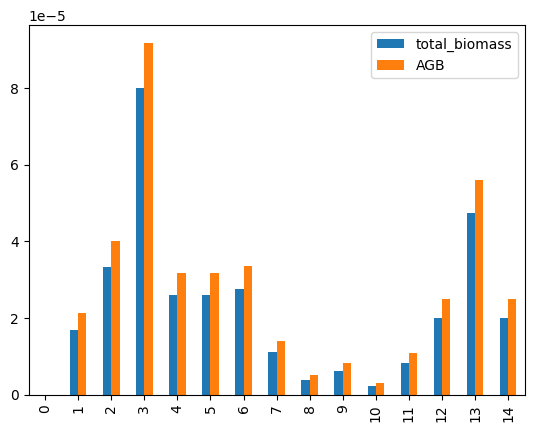

In [331]:
sample_tree_biomasses_python[sample_tree_biomasses_python['tree_species'] == 'BG'][['total_biomass' ,'AGB']].head(15).reset_index(drop = True).plot.bar()

In [335]:
sample_tree_biomasses_python[sample_tree_biomasses_python['tree_species'] == 'BG'][['AGB', 'old_result']].mean()

AGB           0.000248
old_result    0.020026
dtype: float64

# Sampling_avgs

In [47]:
tree_samplings[['tree_height', 'tree_dbh']] = tree_samplings[['tree_height', 'tree_dbh']].astype(float)

In [48]:
proto_sampling_avgs = tree_samplings.groupby(['plot_information_id','taxonomy_id','month_monitoring'])[['tree_height','tree_dbh']].agg('mean').reset_index()

In [49]:
proto_sampling_avgs

,plot_information_id,taxonomy_id,month_monitoring,tree_height,tree_dbh
0,35,23,Apr-24,0.857000,0.0
1,35,23,Jan-24,0.822900,0.0
2,35,23,Jul-23,0.480500,0.0
3,35,23,Jul-24,0.326000,0.0
4,35,23,Oct-23,0.518000,0.0
...,...,...,...,...,...
67,38,25,Jan-24,0.909737,0.0
68,38,25,Jul-24,0.738810,0.0
69,38,26,Apr-24,0.804167,0.0
70,38,26,Jan-24,0.793750,0.0


In [50]:
sampling_avgs = fetch_table_to_df(conn, "SELECT * FROM sampling_avgs")

In [51]:
yes = sampling_avgs.merge(proto_sampling_avgs)

In [52]:
yes

,id,plot_information_id,tree_species,taxonomy_id,avg_h,avg_dbh,month_monitoring,created_at,updated_at,site_id,phase,tree_height,tree_dbh
0,1,35,RA,23,0.481,None,Jul-23,2023-08-06 19:58:18,2023-08-06 19:58:18,None,1,0.480500,0.0
1,2,35,SC,30,0.296,None,Jul-23,2023-08-06 19:58:18,2023-08-06 19:58:18,None,1,0.295667,0.0
2,3,37,RA,23,0.399,None,Jul-23,2023-08-06 19:58:18,2023-08-06 19:58:18,None,1,0.399222,0.0
3,4,35,SA,27,0.358,None,Jul-23,2023-08-06 19:58:18,2023-08-06 19:58:18,None,1,0.358121,0.0
4,5,37,KC,25,0.826,None,Jul-23,2023-08-06 19:58:18,2023-08-06 19:58:18,None,1,0.826301,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,618,38,RA,23,0.424,None,Jul-24,2024-08-21 19:15:03,2024-08-21 19:15:03,None,1,0.403080,0.0
99,619,35,BG,24,0.556,None,Jul-24,2024-08-21 19:15:03,2024-08-21 19:15:03,None,1,0.165532,0.0
100,606,36,SA,27,None,None,Apr-24,2024-05-12 19:28:13,2024-08-21 19:15:03,None,1,0.000000,0.0
101,620,38,KC,25,0.970,None,Jul-24,2024-08-21 19:15:03,2024-08-21 19:15:03,None,1,0.738810,0.0


In [53]:
yes[['avg_h','tree_height']].value_counts()

avg_h  tree_height
0.140  0.000000       2
0.617  0.617333       1
0.761  0.761000       1
0.728  0.624410       1
0.718  0.000000       1
                     ..
0.399  0.341785       1
0.376  0.822900       1
       0.518000       1
0.358  0.729463       1
1.163  1.163333       1
Name: count, Length: 94, dtype: int64

# Data Analytics

In [181]:
data_analytics = fetch_table_to_df(conn, "SELECT * FROM data_analytics")

In [182]:
data_analytics[['site_id','plot_id','taxonomy_id']].value_counts()

site_id  plot_id  taxonomy_id
AA       AA01     0              8
         AA05     0              8
PG       PG-0     0              8
         PG-1     0              8
AA       AA06     0              8
PG       PG-3     0              8
AA       AA04     0              8
         AA03     0              8
         AA02     0              8
SS       SS-3     0              7
         SS-1     0              7
         SS-2     0              7
B        B-1      0              6
P        P-1      0              6
K        K-1      0              6
AA       AA01     4              5
ER       ER-01    72             5
P        P-1      18             5
SS       SS-3     23             5
LQ       LQ-01    64             5
SS       SS-1     23             5
CL       CL-09    64             5
         CL-10    64             5
         CL-04    78             5
         CL-07    78             5
         CL-06    64             5
         CL-03    70             5
         CL-02    64     

In [183]:
data_analytics.key.unique()

array(['rewetting_area', 'cseq_revegetation_annualy',
       'cseq_revegetation_accumulative', 'revegetation_area', 'peat_area',
       'cseq_rewetting_annualy', 'cseq_rewetting_accumulative',
       'mineral_area', 'avg_growth_dbh', 'num_tree_species',
       'avg_growth_height', 'subsidence_a_all', 'subsidence_a',
       'subsidence_c', 'subsidence_c_all', 'restoration_area'],
      dtype=object)

In [184]:
data_analytics

,id,created_at,updated_at,site_id,plot_id,taxonomy_id,monitoring_id,key,value
0,1152,2023-08-27 15:12:48,2023-08-27 15:12:48,B,B-1,0,0,rewetting_area,0.00000
1,125,2023-04-16 21:36:37,2023-05-23 04:20:48,AA,AA06,7,0,cseq_revegetation_annualy,0.00203
2,126,2023-04-16 21:36:37,2023-05-23 04:20:48,AA,AA06,7,0,cseq_revegetation_accumulative,0.00904
3,1153,2023-08-27 15:12:48,2023-08-27 15:12:48,B,B-1,0,0,revegetation_area,2.05000
4,1154,2023-08-27 15:12:48,2023-08-27 15:12:48,B,B-1,0,0,peat_area,2.05000
...,...,...,...,...,...,...,...,...,...
280,1372,2024-08-21 19:15:12,2024-08-21 19:15:12,SS,SS-4,23,0,cseq_revegetation_accumulative,12.48891
281,1345,2023-11-14 03:38:38,2024-08-21 19:15:12,SS,SS-1,0,0,num_tree_species,651.00000
282,423,2023-08-06 15:46:16,2024-08-21 19:15:12,SS,SS-1,24,0,num_tree_species,342.00000
283,431,2023-08-06 15:46:16,2024-08-21 19:15:12,SS,SS-3,26,0,num_tree_species,11308.00000


In [185]:
tree_samplings[tree_samplings['plot_information_id'] == 38]['tree_species'].value_counts()

tree_species
RA     2636
BG     1142
RM      124
KC      122
n/a       2
Name: count, dtype: int64

In [186]:
data_analytics[data_analytics['plot_id'] == 'SS-4']

,id,created_at,updated_at,site_id,plot_id,taxonomy_id,monitoring_id,key,value
254,1355,2024-03-04 09:25:45,2024-05-13 12:10:41,SS,SS-4,0,0,cseq_revegetation_accumulative,7.84775
258,1354,2024-03-04 09:25:45,2024-05-13 12:10:41,SS,SS-4,0,0,cseq_revegetation_annualy,6.52490
266,1356,2024-03-04 09:25:46,2024-08-21 19:15:12,SS,SS-4,0,0,num_tree_species,7517.00000
267,1358,2024-03-04 09:25:46,2024-08-21 19:15:12,SS,SS-4,24,0,num_tree_species,1358.00000
268,1359,2024-03-04 09:25:46,2024-08-21 19:15:12,SS,SS-4,25,0,num_tree_species,142.00000
269,1360,2024-03-04 09:25:46,2024-08-21 19:15:12,SS,SS-4,26,0,num_tree_species,252.00000
272,1361,2024-03-04 09:25:46,2024-08-21 19:15:12,SS,SS-4,26,0,avg_growth_height,0.14038
273,1362,2024-03-04 09:25:46,2024-08-21 19:15:12,SS,SS-4,25,0,avg_growth_height,0.12033
274,1363,2024-03-04 09:25:46,2024-08-21 19:15:12,SS,SS-4,23,0,avg_growth_height,0.35698
275,1364,2024-03-04 09:25:46,2024-08-21 19:15:12,SS,SS-4,24,0,avg_growth_height,0.29280


## Update tree_monitorings components

In [187]:
tree_monitorings['plot_id'] = tree_monitorings['tree_id'].apply(lambda x: [y for y in plot_informations['plot_id'] if y in x]).str.get(0)

In [188]:
site_dict = site_informations.set_index('id')['site_id'].to_dict() 

tree_monitorings['site_id'] = [plot_informations.loc[plot_informations['plot_id'] == plot_id, 'site_information_id'].values[0] 
                if plot_id in plot_informations['plot_id'].values else None
                for plot_id in tree_monitorings['plot_id']]

tree_monitorings['site_id'] = tree_monitorings['site_id'].map(site_dict)

In [189]:
monitoring_height_mean = pd.Series.to_frame(tree_monitorings.groupby(['site_id', 'plot_id'])['tree_height'].agg("mean")).reset_index()

In [190]:
monitoring_dbh_mean = pd.Series.to_frame(tree_monitorings.groupby(['site_id', 'plot_id'])['tree_dbh'].agg("mean")).reset_index()

In [194]:
monitoring_result_mean = pd.Series.to_frame(tree_biomasses_python.groupby(['site_id','plot_id'])['carbon'].agg('mean')).reset_index()

KeyError: 'site_id'

In [191]:
data_analytics[(data_analytics['plot_id'] == 'BB-04') & (data_analytics['site_id'] == 'BB')]['value']

109    0.00623
110    0.03587
129    1.00000
144    0.29350
162    0.90135
Name: value, dtype: object